# MPL model on MNIST

In [1]:
using Knet, Plots, Statistics, LinearAlgebra, Base.Iterators, Random, StatsBase
ENV["COLUMNS"] = 80
ARRAY = KnetArray{Float64}
XSIZE=49   # input dimension
YSIZE=10    # output dimension
HIDDEN=10   # hidden layer size
WSIZE=HIDDEN*XSIZE + HIDDEN + YSIZE*HIDDEN + YSIZE
WZERO=0.001 # init w with randn()*WZERO
BATCHSIZE=100 # minibatch size
LAMBDA=1e-2 # regularization parameter
LR=1e-2     # learning rate
MITER=10^5 # iterations for finding minimum
DITER=10^5  # iterations for diffusion tensor
CITER=5*10^7  # iterations for covariance trajectory 
CFREQ=10^2  # keep every CFREQ points on trajectory
@show gpu();

gpu() = 0


# Define regularized mlp model with softmax loss

In [2]:
function pred(w,x)
    b1 = w[1:HIDDEN]
    b2 = w[HIDDEN+1:HIDDEN+YSIZE]
    w1 = reshape(w[HIDDEN+YSIZE+1:HIDDEN+YSIZE+HIDDEN*XSIZE],HIDDEN,XSIZE)
    w2 = reshape(w[HIDDEN+YSIZE+HIDDEN*XSIZE+1:end],YSIZE,HIDDEN)
    return b2 .+ w2 * relu.(b1 .+ w1 * x)
end
loss(w,x,y;λ=LAMBDA) = nll(pred(w,x), y) + (λ/2) * sum(abs2,w[1+HIDDEN+YSIZE:end]) # do not regularize biases

loss (generic function with 1 method)

# Load MNIST data

In [3]:
xtrn,ytrn,xtst,ytst = Knet.load("mnist7x7.jld2","xtrn","ytrn","xtst","ytst")
atrn,atst = ARRAY(xtrn), ARRAY(xtst) # GPU copies for batch training
println.(summary.((xtrn,ytrn,xtst,ytst,atrn,atst)));

49×60000 Array{Float32,2}
60000-element Array{UInt8,1}
49×10000 Array{Float32,2}
10000-element Array{UInt8,1}
49×60000 KnetArray{Float64,2}
49×10000 KnetArray{Float64,2}


# Minibatch data

In [4]:
# Minibatching for SGD-I, i.e. with replacement. Knet.minibatch can't do this, we define new struct
struct MB; x; y; n; end
Base.Iterators.IteratorSize(::Type{MB}) = Base.IsInfinite() # need this for collect to work
Base.iterate(d::MB, s...)=(r = rand(1:length(d.y),d.n); ((ARRAY(mat(d.x)[:,r]), d.y[r]), true))
dtrn = MB(xtrn, ytrn, BATCHSIZE)
println.(summary.(first(dtrn)));

49×100 KnetArray{Float64,2}
100-element Array{UInt8,1}


# Find minimum

In [5]:
LAMBDA,MITER

(0.01, 100000)

In [6]:
# Find minimum without minibatching
# ~90 iters/sec, LAMBDA=1e-2, MITER=100000, converges in 18:35 to 
# (trnloss = 0.7221934812117925, nll = 0.4066347559405784, reg = 0.31555872527121415)
wminfile = "mnist7x7mlp-wmin-$LAMBDA-$MITER.jld2"
if !isfile(wminfile)
    wmin = Param(ARRAY(WZERO*randn(WSIZE)))
    args = repeat([(wmin,atrn,ytrn)],MITER)
    Knet.gc()
    losses = collect(progress(adam(loss,args)))
    Knet.save(wminfile, "wmin", wmin, "losses", losses)
else
    wmin, losses = Knet.load(wminfile, "wmin", "losses");
end
@show summary(wmin)

summary(wmin) = "610-element Param{KnetArray{Float64,1}}"


"610-element Param{KnetArray{Float64,1}}"

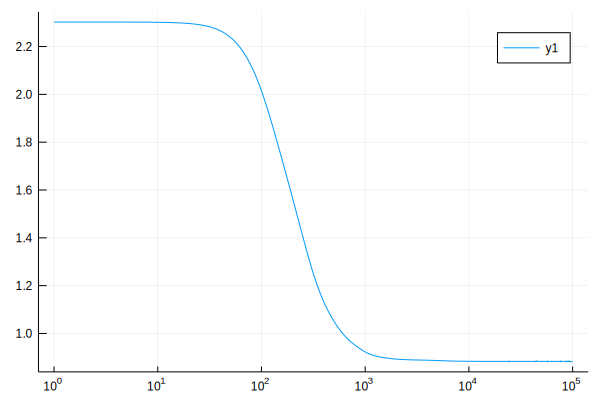

In [7]:
plot(losses,xaxis=:log)

In [8]:
println.((
(trnloss=loss(wmin,atrn,ytrn),nll=nll(pred(wmin,atrn),ytrn),reg=(LAMBDA/2)*sum(abs2,wmin[1+HIDDEN+YSIZE:end])),
(tstloss=loss(wmin,atst,ytst),nll=nll(pred(wmin,atst),ytst),reg=(LAMBDA/2)*sum(abs2,wmin[1+HIDDEN+YSIZE:end])),
(trnacc=accuracy(pred(wmin,atrn),ytrn),tstacc=accuracy(pred(wmin,atst),ytst))));

(trnloss = 0.8820587867548113, nll = 0.521121458819621, reg = 0.36093732793519034)
(tstloss = 0.8579247353257466, nll = 0.4969874073905563, reg = 0.36093732793519034)
(trnacc = 0.8679333333333333, tstacc = 0.8764)


# Hessian of loss around minimum

In [9]:
function hessian(loss,w,x,y)
    ∇loss = grad(loss)
    ∇lossi(w,x,y,i) = ∇loss(w,x,y)[i]
    ∇∇lossi = grad(∇lossi)
    w = value(w)
    n = length(w)
    h = similar(Array(w),n,n)
    for i in progress(1:n)
        h[:,i] .= Array(vec(∇∇lossi(w,x,y,i)))
    end
    return h
end

hessian (generic function with 1 method)

In [10]:
# Compute hessian: ~23 secs
hessfile = "mnist7x7mlp-hess-$LAMBDA.jld2"
if !isfile(hessfile)
    Knet.gc()
    H = hessian(loss,wmin,atrn,ytrn)
    Knet.save(hessfile,"h",H)
else
    H = Knet.load(hessfile,"h")
end
summarystats(vec(H)) |> dump
@show norm(H), norm(H-H');

StatsBase.SummaryStats{Float64}
  mean: Float64 0.0004771668342048756
  min: Float64 -0.35026388512252943
  q25: Float64 -0.001346582960185295
  median: Float64 -7.81642984139244e-5
  q75: Float64 0.0008916595630724864
  max: Float64 1.31947586832304
  nobs: Int64 372100
  nmiss: Int64 0
(norm(H), norm(H - H')) = (9.603858489705583, 2.236030289652178e-15)


# Eigenvalues of the Hessian

In [11]:
# Unfortunately I cannot seem to get rid of small negative eigenvalues in spite of strong regularization
eigenH = eigen(Symmetric(H)) # ~1s
eigenH.values'

1×610 Adjoint{Float64,Array{Float64,1}}:
 -7.88219e-5  -3.36952e-5  -1.72675e-5  …  3.12008  3.93716  4.25945  4.36823

StatsBase.SummaryStats{Float64}
  mean: Float64 0.06763007168860719
  min: Float64 -7.88218588558316e-5
  q25: Float64 0.01100593803243209
  median: Float64 0.015977248763388595
  q75: Float64 0.024487109565687216
  max: Float64 4.368228721927913
  nobs: Int64 610
  nmiss: Int64 0


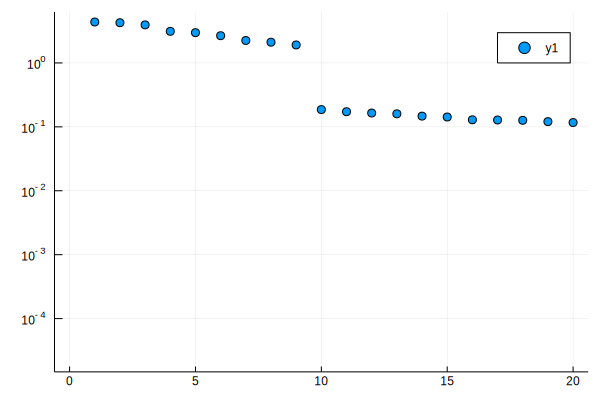

In [12]:
summarystats(eigenH.values) |> dump
scatter(reverse(eigenH.values) .+ 0.0001, yscale=:log10,xlim=[0,20])

# Diffusion Tensor

In [13]:
function diffusiontensor(loss,w,x,y;iters=DITER,lr=LR,batchsize=BATCHSIZE)
    ∇loss = grad(loss)
    grad0 = Array(∇loss(w, ARRAY(x), y))
    data = MB(x,y,batchsize)
    grads = zeros(length(w), iters)
    for (i,d) in progress(enumerate(take(data,iters)))
        grads[:,i] .= Array(∇loss(w,d...))
    end
    prefac = (lr^2)/(2iters)
    grads = grad0 .- grads
    @time v = prefac * (grads * grads')
    return v
end

diffusiontensor (generic function with 1 method)

In [14]:
LAMBDA,LR,BATCHSIZE,DITER

(0.01, 0.01, 100, 100000)

In [15]:
dtfile = "mnist7x7mlp-diff-$LAMBDA-$LR-$BATCHSIZE-$DITER.jld2"
if !isfile(dtfile)
    Knet.gc()
    D = diffusiontensor(loss,wmin,xtrn,ytrn) # ~1600 iters/sec, 60secs total
    Knet.save(dtfile,"D",D)
else
    D = Knet.load(dtfile,"D")
end
summarystats(vec(D)) |> dump
@show norm(D),norm(D-D');

100.00%┣████████████████████████████████▉┫ 100000/100000 [01:40/01:40, 998.60i/s]
  1.608608 seconds (1.13 M allocations: 60.105 MiB, 9.34% gc time)
StatsBase.SummaryStats{Float64}
  mean: Float64 1.2805236355314063e-10
  min: Float64 -1.1762005907539919e-7
  q25: Float64 -4.066257169399284e-10
  median: Float64 -2.3937130183011928e-11
  q75: Float64 2.7868880861578146e-10
  max: Float64 4.1789644133242206e-7
  nobs: Int64 372100
  nmiss: Int64 0
(norm(D), norm(D - D')) = (2.816065809871478e-6, 0.0)


# Eigenvalues of the diffusion tensor

In [16]:
eigenD = eigen(Symmetric(D)) # ~1s
eigenD.values'

1×610 Adjoint{Float64,Array{Float64,1}}:
 -1.1555e-22  -3.36162e-23  -1.80679e-23  …  1.241e-6  1.3063e-6  1.41328e-6

StatsBase.SummaryStats{Float64}
  mean: Float64 1.630894341574815e-8
  min: Float64 -1.155497833497841e-22
  q25: Float64 1.52701401591664e-10
  median: Float64 1.0376860589603764e-9
  q75: Float64 3.713994540254368e-9
  max: Float64 1.4132756816405355e-6
  nobs: Int64 610
  nmiss: Int64 0


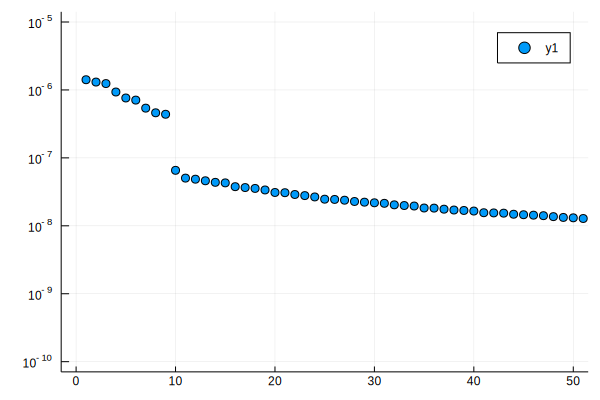

In [17]:
summarystats(eigenD.values) |> dump
scatter(reverse(eigenD.values) .+ 1e-19, yscale=:log10,xlim=[0,50],ylim=[1e-10,1e-5])

# Record trajectory with SGD starting at minimum

In [18]:
LAMBDA,LR,BATCHSIZE,CITER,CFREQ

(0.01, 0.01, 100, 50000000, 100)

In [19]:
# Trajectory of w starting from wmin recorded after each update: 
# ~950 updates/sec, ~18 mins total for CITER=1M
trajfile = "mnist7x7mlp-traj-$LAMBDA-$LR-$BATCHSIZE-$CITER-$CFREQ.jld2"
if !isfile(trajfile)
    w = Param(ARRAY(value(wmin)))
    data = MB(xtrn,ytrn,BATCHSIZE)
    d = take(data,CITER)
    W = zeros(eltype(w),length(w),div(CITER,CFREQ))
    f(x,y) = loss(w,x,y)
    Knet.gc()
    i = 0
    for t in progress(sgd(f,d; lr=LR))
        i += 1; (div,rem)=divrem(i,CFREQ)
        if rem == 0
            W[:,div] = Array(vec(w))
        end
    end
    Knet.save(trajfile,"W",W)
else
    W = Knet.load(trajfile,"W")
end
summary(W)

Excessive output truncated after 524289 bytes.

9.17e-01  11.96%

"610×500000 Array{Float64,2}"

  4.772902 seconds (1.10 M allocations: 512.112 MiB, 35.98% gc time)


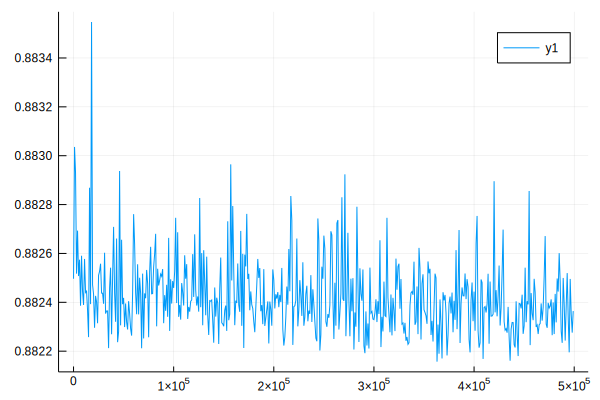

In [20]:
# Plot losses on whole dataset, first steps seem transient
r = 1:1000:size(W,2)
@time plot(r, [loss(ARRAY(W[:,i]),atrn,ytrn) for i in r])

In [74]:
rr1,rr2 = rand(1:size(W,1)),rand(1:size(W,1));rr1,rr2 = 300,401

(300, 401)

(rr1, rr2) = (rand(1:size(W, 1)), rand(1:size(W, 1))) = (229, 142)


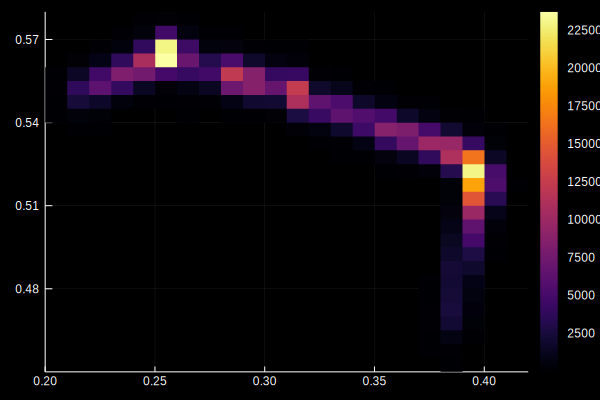

In [75]:
# Plot trajectory of two random dimensions
@show rr1,rr2 = rand(1:size(W,1)),rand(1:size(W,1))
if norm(W[rr1,:]) > 0 && norm(W[rr2,:]) > 0
    histogram2d(W[rr1,:],W[rr2,:],background_color="black")
end

In [23]:
# Minibatch training seems to converge to a slightly worse spot
w0 = Array(value(wmin))
μ = mean(W[:,2500:end],dims=2)
w1 = W[:,end]
@show norm(w0), norm(μ), norm(w0 - μ)
@show extrema(w0), extrema(μ), extrema(w0 - μ)
@show mean(abs.(w0 - μ) .> 0.01)
@show loss(w0,xtrn,ytrn)
@show loss(μ,xtrn,ytrn)
@show loss(w1,xtrn,ytrn)

(norm(w0), norm(μ), norm(w0 - μ)) = (13.354821971483691, 11.651713802488153, 4.148933437191146)
(extrema(w0), extrema(μ), extrema(w0 - μ)) = ((-4.5020360512474875, 4.638201459914599), (-3.2510713764388113, 3.2112971211346064), (-1.521306983709375, 1.7324825557087262))
mean(abs.(w0 - μ) .> 0.01) = 0.521311475409836
loss(w0, xtrn, ytrn) = 0.8820587867548114
loss(μ, xtrn, ytrn) = 0.8825957154425419
loss(w1, xtrn, ytrn) = 0.8825345878418683


0.8825345878418683

# Covariance of SGD trajectory around minimum

In [92]:
#Wstable = W[:,2500:end];  @show summary(Wstable)
Wstable = W
μ = mean(Wstable,dims=2); @show summary(μ)
Wzero = Wstable .- μ;     @show summary(Wzero)
Σ = (Wzero * Wzero') / size(Wzero,2)
@show summary(Σ)
@show norm(Σ)
@show extrema(Σ)
@show norm(diag(Σ));

summary(μ) = "610×1 Array{Float64,2}"
summary(Wzero) = "610×500000 Array{Float64,2}"
summary(Σ) = "610×610 Array{Float64,2}"
norm(Σ) = 4.0009577190945675
extrema(Σ) = (-0.5446024182509656, 0.6895601243086246)
norm(diag(Σ)) = 1.1487994173622518


In [173]:
# check for convergence
n = div(size(W,2),2)
w1 = W[:,end-2n+1:end-n]
w2 = W[:,end-n+1:end]
w1 = w1 .- mean(w1,dims=2)
w2 = w2 .- mean(w2,dims=2)
Σ1 = (w1 * w1') / size(w1,2)
Σ2 = (w2 * w2') / size(w2,2);

In [174]:
# The variances (diagonal elements)
invd1,invd2 = diag(Σ1),diag(Σ2)
norm(invd1),norm(invd2),norm(invd1-invd2),norm(invd1-invd2)/norm(invd2)

(0.45282194946845533, 0.3453513354582926, 0.4149690269979666, 1.2015851232985362)

In [175]:
# The INVERSE variances (diagonal elements) - demonstrating that the small variances converge
invd1,invd2 = 1 ./ diag(Σ1) , 1 ./ diag(Σ2)
norm(invd1),norm(invd2),norm(invd1-invd2),norm(invd1-invd2)/norm(invd2)

(4.296865651389346e6, 4.358887368946705e6, 745024.3568800994, 0.17092076344705584)

In [179]:
# The off-diagonal elements
norm(Σ1),norm(Σ2),norm(Σ1-Σ2),norm(Σ1-Σ2)/norm(Σ2)

(1.415427107745401, 1.0691163738948295, 1.4346021799621682, 1.3418578323104908)

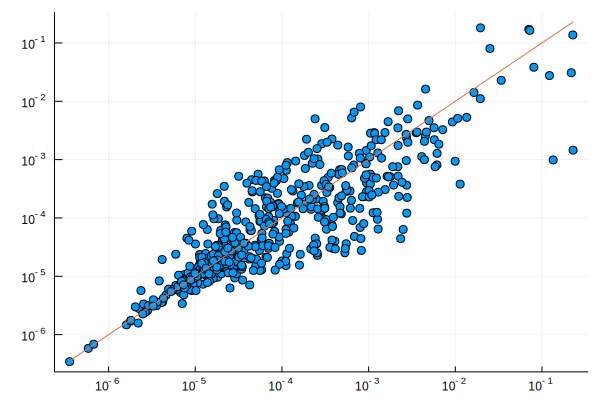

In [180]:
Nw = length(W[:,1])
scatter(diag(Σ1),diag(Σ2),xaxis=:log,yaxis=:log,legend=false)
plot!(diag(Σ1),diag(Σ1))

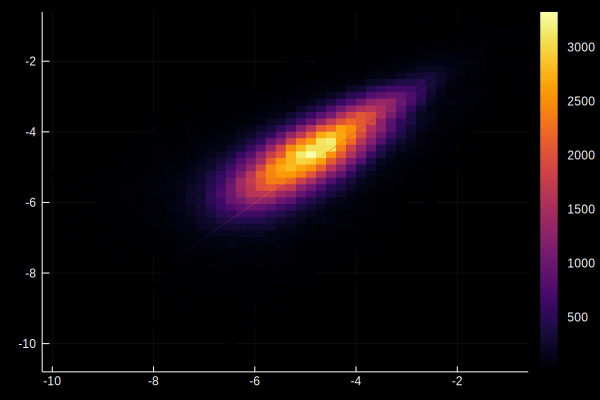

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [195]:
## off-diagonals..

v1 = log10.(abs.(reshape(Σ1,Nw^2,1)))
v2 = log10.(abs.(reshape(Σ2,Nw^2,1)))
histogram2d(v1,v2,nbins=50,background_color="black")
histogram2d!(v1,v1,nbins=450) # show the diagonal as reference
#plot!(v1,v1)

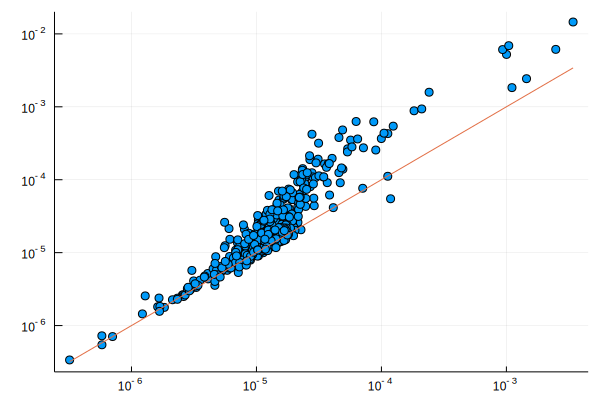

In [169]:
n = div(size(W,2),16)
w1 = W[:,end-2n+1:end-n]
w2 = W[:,end-n+1:end]
w1 = w1 .- mean(w1,dims=2)
w2 = w2 .- mean(w2,dims=2)
Σ1 = (w1 * w1') / size(w1,2)
Σ2 = (w2 * w2') / size(w2,2);
Nw = length(W[:,1])
scatter(diag(Σ1),diag(Σ2),xaxis=:log,yaxis=:log,legend=false)
plot!(diag(Σ1),diag(Σ1))

In [85]:
# Clean up
w1=0;w2=0;Σ1=0;Σ2=0;Knet.gc()

### Check Lyapunov equation

In [29]:
summary.((H,D,Σ))

("610×610 Array{Float64,2}", "610×610 Array{Float64,2}", "610×610 Array{Float64,2}")

In [30]:
a = H*Σ + Σ*H
b = (2/LR)*D
norm(a),norm(b),norm(a-b),norm(a-b)/norm(b)

(0.36999432985531205, 0.0005632131619742955, 0.3699878087448069, 656.9232285833774)

In [137]:
v = [11,12,13,14,15,16,17,18,19,20]; @show r = rand(1:10,3);v[collect(r)]

r = rand(1:10, 3) = [1, 8, 5]


3-element Array{Int64,1}:
 11
 18
 15

## Covariance eigenspace

In [31]:
Knet.gc()

In [32]:
@time eigenΣ = eigen(Σ);

  0.653387 seconds (1.19 M allocations: 67.996 MiB, 6.61% gc time)


In [33]:
 ΛΣ = eigenΣ.values; O = eigenΣ.vectors;

In [34]:
ΛΣ # verify that the last eigenvectors are the largest ones

610-element Array{Float64,1}:
 -2.0804931715723473e-16
 -7.431943034495938e-17 
 -2.3447341224619758e-17
 -1.1820886083707594e-18
 -5.7743300945040205e-19
 -6.241775829147888e-20 
 -1.1954783503149379e-20
  2.02658660450734e-18  
  4.643993090627379e-17 
  2.5829233284996796e-16
  3.883862680127408e-13 
  1.459267167463012e-8  
  2.1567411354594044e-8 
  ⋮                     
  9.023992707244983e-5  
  0.00011728480860077976
  0.0002486675648577028 
  0.00047367950352850856
  0.0008619476078732689 
  0.0015708805929869733 
  0.0021324581114187105 
  0.007017443683861751  
  0.017160427112482217  
  0.05443756734911182   
  0.29386361688078283   
  3.989735762907425     

In [35]:
# transform the trajectory to the eigenbasis, keeping top Neig eigenvectors.
# Do the matrix mult in gpu in batches, since memory is not enough
# This is effectively the same as Weig=(O'*W)[end-Neig+1:end,:]

Neig=10 # number of top eigenvectors to keep
Or = O[:,end-Neig+1:end]; # reduced transformation matrix to the eigenbasis
ΛΣr = ΛΣ[end-Neig+1:end]
NB=div(div(CITER,CFREQ),10)
Weig = zeros(Neig,div(CITER,CFREQ))
for n=0:9
    Weig[:,NB*n+1:NB*(n+1)] = Array(ARRAY(Or')*ARRAY(W[:,NB*n+1:NB*(n+1)]));
end
#W=0;
Knet.gc() # to make space in gpu memory

In [36]:
## check Einstein relation in top Neig eigen-directions of Σ
aa = Or'*a*Or
bb = Or'*b*Or
norm(aa),norm(bb)/norm(aa),norm(aa-bb)/norm(aa)

(0.04751968540588989, 7.597422938211844e-5, 0.9999881805728985)

In [62]:
# pick two eigen directions
Xid = Neig
Yid = Neig-1

Wx = Weig[Xid,:]
Wy = Weig[Yid,:]

#COV_ss = O'*Σ*O
#COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]])
COV_xy_inv = Diagonal([1/ΛΣr[Xid],1/ΛΣr[Yid]]) + zeros(2,2)
μeig = Or'*μ
W0eig = Or'*w0;

In [63]:
myhplot = histogram2d(Wx,Wy
    ,bins=100
    ,aspect_ratio=1
    ,background_color="black"
);

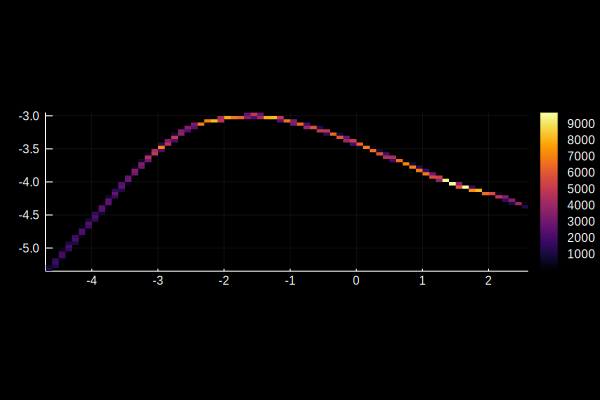

  0.281817 seconds (452.60 k allocations: 15.391 MiB)


In [64]:
@time display(myhplot)

In [65]:
# Construct a grid enclosing the steady-state trajectory
minmaxdiff(t) = maximum(t)-minimum(t)

function makegrid(xvec,yvec,mean,xindex,yindex;Nx=50,Ny=50,zoom=0.35)
    Lx,Ly = minmaxdiff(xvec),minmaxdiff(yvec)
    xrange,yrange = zoom*Lx,zoom*Ly
    dx,dy = xrange/Nx,yrange/Ny
    x = collect(-xrange:dx:xrange) .+ mean[xindex]
    y = collect(-yrange:dy:yrange) .+ mean[yindex]

    Nw = length(mean) # number of dimensions
    # some mumbo-jumbo for calculating weights corresponding to grid points
    Identity = Diagonal(ones(Nw,Nw)); # unit matrix
    xmask = Identity[:,xindex];
    ymask = Identity[:,yindex];
    Imask = Identity - xmask*xmask' - ymask*ymask' # set two diagonal elements to zero
    return (x,y,Imask,xmask,ymask)
end

makegrid (generic function with 1 method)

In [41]:
(x,y,Imask,xmask,ymask) = makegrid(Wx,Wy,W0eig,Xid,Yid;Nx=12,Ny=12,zoom=0.5)
#(x,y,Imask,xmask,ymask) = makegrid(Wx,Wy,μeig,Xid,Yid;Nx=4,Ny=4);

UndefVarError: UndefVarError: Wx not defined

In [42]:
meanXY = W0eig[[Xid Yid]]
# Contours of the fit mv-Gaussian
ffit(s,t) = -(([s t]-meanXY)*COV_xy_inv*([s t]-meanXY)')[1]
Ffit(s,t) = 1e3*ffit(s,t)/ffit(x[end],y[end])
contour!(x,y,Ffit
    ,linestyle=:dash
    ,levels=10
    ,linewidth=2
)

UndefVarError: UndefVarError: Yid not defined

In [43]:
# contours of loss
midx = div(length(x),2)
midy = div(length(y),2)
#fexp(s,t) = 1e5*(loss(Or*(Imask*W0eig + s*xmask + t*ymask),xtrn,ytrn) - loss(w0,xtrn,ytrn))
fexp(s,t) = 1e5*(loss(Or*(Imask*μeig + s*xmask + t*ymask),xtrn,ytrn) - loss(w0,xtrn,ytrn))
logfexpmidp1 = log(1+fexp(x[midx],y[midy]))
Flossxy(s,t) = 1e2*(log((1+fexp(s,t))) - logfexpmidp1)

UndefVarError: UndefVarError: x not defined

In [44]:
@time contour!(x,y,Flossxy
    ,levels=10
    ,linewidth=2
)

UndefVarError: UndefVarError: x not defined

## Areal velocity

In [45]:
η = LR

0.01

In [46]:
# record the theoretical areal velocities
A = Or'*(η*H*Σ - D)*Or/η^2
AA = Or'*(η/2)*(H*Σ - Σ*H)*Or/η^2;

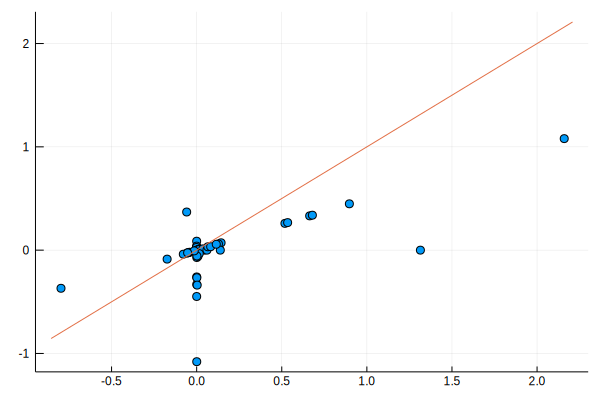

In [47]:
# This effectively shows the degree to which the Lyapunov equation is satisfied.
# Both A and AA theoretical values of the current, calculated through two different
# expressions (involving D,H,Σ, above) related through the Lyapunov equation.

scatter(reshape(A,Neig^2,1),reshape(AA,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
g(x)=x
plot!(g)

In [48]:
# ## Collect trajectory data for areal velocity calculation
# ## Keeping 10^7 steps for 1000+ variables in memory or hard disk is a problem.
# ## Better keep track of top eigen-components (we already know them)


# # make space
# # H=0;D=0;Σ=0;W=0;Wstable=0;Knet.gc();Weig=0

# CITER = 10^7

# trajfile = "mnist7x7_traj_eig$Neig-$LAMBDA-$LR-$BATCHSIZE-$CITER.jld2"
# if !isfile(trajfile)
#     Knet.gc()
#     w = Param(ARRAY(value(wmin)))
#     data = MB(xtrn,ytrn,BATCHSIZE)
#     d = take(data,CITER)
#     Weig = ARRAY(zeros(eltype(w),Neig,CITER))
#     f(x,y) = loss(w,x,y)
#     i = 0
#     for t in progress(sgd(f,d; lr=LR))
#         i += 1
#         Weig[:,i] = ARRAY(O[:,Nweights-Neig+1:Nweights]')*vec(w)
#     end
#     Knet.save(trajfile,"Weig",Weig)
# else
#     Weig = Knet.load(trajfile,"Weig")
# end
# summary(Weig)

In [49]:
function arealvelo_trans(traj,x,y,center)
    N = length(traj[:,1])
    Area=zeros(N);
    Areasum=zeros(N);
    rad=0;
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[n-1,x]-center[x],traj[n-1,y]-center[y],0]
        v2=[traj[n,x]-center[x],traj[n,y]-center[y],0]
        rad += norm(v2) # mean radius of the trajectory - used for normalization
        Area[n] = cross(v1,v2)[3]/2
        Areasum[n] = Areasum[n-1]+Area[n]
#        Areasum[n-1] /= n-2
    end
#    Areasum[N] /= N-1    
    return Areasum,rad/(N-1)
end

arealvelo_trans (generic function with 1 method)

In [50]:
rad = zeros(Neig,Neig); # mean radius of w projections for each eigenvector pair

In [51]:
np = length(Weig[1,:]) # length of the trajectory
nskip = div(np,1000) # pick sampling rate to plot with 1000 points

500

In [52]:
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);

UndefVarError: UndefVarError: Yid not defined

In [53]:
orbit_area = π*rad[Xid,Yid]^2

UndefVarError: UndefVarError: Yid not defined

In [54]:
Xid,Yid=Neig,Neig-1
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

UndefVarError: UndefVarError: area_vs_t not defined

In [55]:
Xid,Yid=Neig-1,Neig-5
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);
orbit_area = π*rad[Xid,Yid]^2
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

UndefVarError: UndefVarError: W0eig not defined

In [56]:
function arealvelocity(traj,x,y,center)
    N = length(traj[:,1])
    Area=zeros(N-1);
    Areasum=0
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[n-1,x]-center[x],traj[n-1,y]-center[y],0]
        v2=[traj[n,x]-center[x],traj[n,y]-center[y],0]
        Areasum += cross(v1,v2)[3] # this is twice the area of the triangle
    end
    return Areasum/(2*N)
end

av = zeros(Neig,Neig)
for i in progress(1:Neig-1)
    for j = i+1:Neig
        av[i,j] = arealvelocity(Array(Weig)',i,j,W0eig)
        av[j,i] = -av[i,j]
    end
end

1.00e+00  11.11%┣████                                ┫ 1/9 [00:00/00:01, 9.79i/s]

UndefVarError: UndefVarError: W0eig not defined

In [57]:
B = av#/η^2

10×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

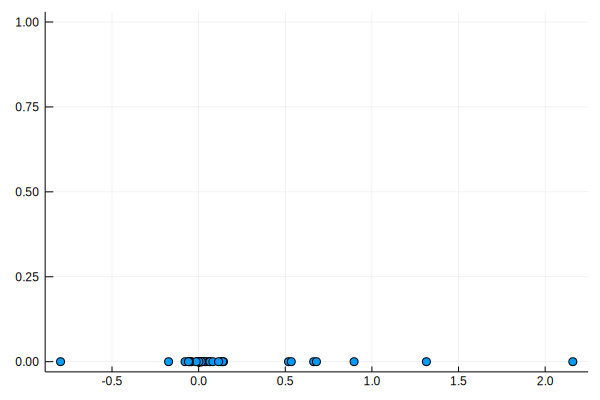

In [58]:
# Compare the computed current with the analytical expression (η*H*Σ - D)/η²
scatter(reshape(A,Neig^2,1),reshape(B,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
# g(x)=x
# plot!(g)

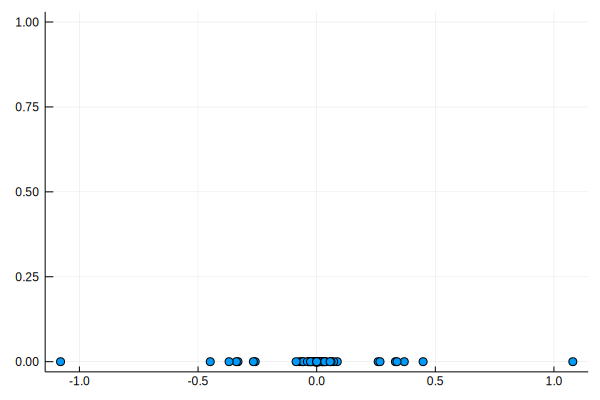

In [59]:
# Compare the computed current with the analytical expression (H*Σ - Σ*H)/η²

scatter(reshape(AA,Neig^2,1),reshape(B,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
# g(x)=x
# plot!(g)

In [60]:
findmax(A)

(2.1595955440418146, CartesianIndex(3, 10))

In [61]:
findmax(AA)

(1.0795701826493114, CartesianIndex(3, 10))